## 币安期货多币种对冲策略最近的复盘和分钟级K线回测的结果

币安多币种对冲策略的研究报告已经发了3篇，这里是第4篇。前三篇的连接，没看的一定要再看一遍，可以了解策略的成型思路，具体参数的设置和策略逻辑。

- [千团大战]币安期货多币种对冲策略研究（第1篇）：https://www.fmz.com/digest-topic/5294
- [千团大战]币安期货做空超涨做多超跌策略重要优化（第2篇）https://www.fmz.com/digest-topic/5364
- [千团大战]币安期货做空超涨做多超跌策略风险分析（第3篇）https://www.fmz.com/digest-topic/5400

很多人还不会使用研究环境，这里有一篇简单的入门介绍:https://www.fmz.com/bbs-topic/4388

本篇文章要复盘以下最近1周的实盘情况，总结一下得失。由于爬取了最近两个月的币安期货分钟线数据，可以更新下原来1hK线的回测结果，更能说明一些参数设置的含义。

In [1]:
# 需要导入的库
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [91]:
symbols = ['BTC','ETH', 'BCH', 'XRP', 'EOS', 'LTC', 'TRX', 'ETC', 'LINK', 'XLM', 'ADA', 'XMR', 'DASH', 'ZEC', 'XTZ', 'BNB', 'ATOM', 'ONT', 'IOTA', 'BAT', 'VET', 'NEO', 'QTUM', 'IOST']

## 分钟线数据

数据从2月21日到4月15下午两点，共77160\*24条，这大大降低了我们的回测速度，回测引擎也不够高效，可以自行优化。以后有需要，我会定期追踪一下最新数据。

In [306]:
price_usdt = pd.read_csv('https://www.fmz.com/upload/asset/2b1fa7ab641385067ad.csv',index_col = 0)
price_usdt.shape

(77160, 24)

In [309]:
price_usdt.index = pd.to_datetime(price_usdt.index,unit='ms')
price_usdt_norm = price_usdt/price_usdt.fillna(method='bfill').iloc[0,]
price_usdt_btc = price_usdt.divide(price_usdt['BTC'],axis=0)
price_usdt_btc_norm = price_usdt_btc/price_usdt_btc.fillna(method='bfill').iloc[0,]

In [252]:
class Exchange:
    
    def __init__(self, trade_symbols, leverage=20, commission=0.00005,  initial_balance=10000, log=False):
        self.initial_balance = initial_balance #初始的资产
        self.commission = commission
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.df = pd.DataFrame(columns=['margin','total','leverage','realised_profit','unrealised_profit'])
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 'total':initial_balance, 'leverage':0, 'fee':0}}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0, 'margin':0, 'unrealised_profit':0,'fee':0}
            
    def Trade(self, symbol, direction, price, amount, msg=''):
        if self.date and self.log:
            print('%-20s%-5s%-5s%-10.8s%-8.6s %s'%(str(self.date), symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))
            
        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        
        self.account['USDT']['realised_profit'] -= price*amount*self.commission #扣除手续费
        self.account['USDT']['fee'] += price*amount*self.commission
        self.account[symbol]['fee'] += price*amount*self.commission
        
        if cover_amount > 0: #先平仓
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #释放保证金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
        return True
    
    def Buy(self, symbol, price, amount, msg=''):
        self.Trade(symbol, 1, price, amount, msg)
        
    def Sell(self, symbol, price, amount, msg=''):
        self.Trade(symbol, -1, price, amount, msg)
        
    def Update(self, date, close_price): #对资产进行更新
        self.date = date
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in self.trade_symbols:
            if np.isnan(close_price[symbol]):
                continue
            self.account[symbol]['unrealised_profit'] = (close_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price[symbol]
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price[symbol]
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
        
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']/self.account['USDT']['total'],4)*self.leverage
        self.df.loc[self.date] = [self.account['USDT']['margin'],self.account['USDT']['total'],self.account['USDT']['leverage'],self.account['USDT']['realised_profit'],self.account['USDT']['unrealised_profit']]

## 过去一周复盘

策略代码4月10号在微信群放出，刚开始就有一批人跑起了策略2——做空超涨做多超跌，开始的三天，收益很好，回撤很低，迅速激发了大家的热情。部分人放大了杠杆，甚至是满杠杆操作，收益一天就干到了10%。策略广场也公开了大量的实盘，很多人开始不满足与保守的推荐参数，纷纷放大了交易量。4月13后但由于BNB的独立行情，策略开始回撤和横盘，如果按默认3%的trade_value来看，大概回撤了1%。但很多人由于放大的参数，导致赚的少，亏得多。这一波回撤还算及时，让大家冷静了一些。
<img src='https://www.fmz.com/upload/asset/29cd534a29206ac4bbd.png'>

首先看一下策略二的全币种回测，这里由于是分钟更新，Alpha参数需要调整。从实盘来看，曲线走势相符，说明我们的回测可以作为很强的参考，净值从4.13日到达净值顶点一直处于回撤和横盘阶段。

In [358]:
Alpha = 0.001
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = list(set(symbols))
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.00075,log=False)
trade_value = 300
for row in price_usdt.iloc[-7500:].iterrows():
    e.Update(row[0], row[1])
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        if aim_value - now_value > 0.5*trade_value:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -0.5*trade_value:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2a = e

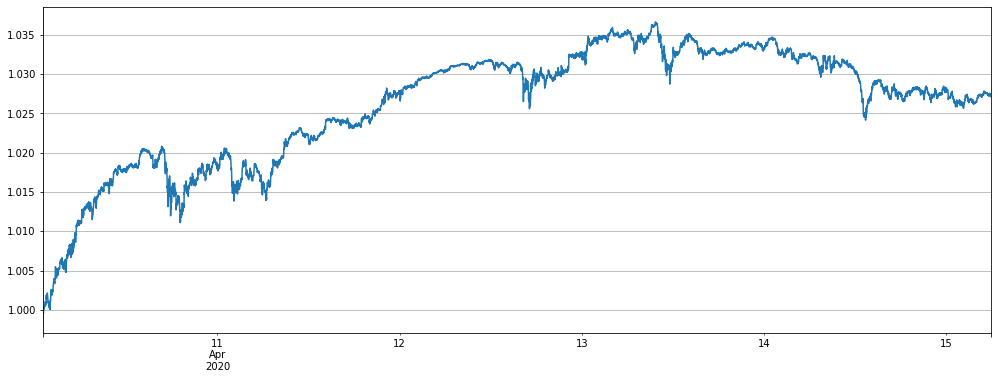

In [359]:
(stragey_2a.df['total']/stragey_2d.initial_balance).plot(figsize=(17,6),grid = True);

策略1，做空山寨币策略实现了正收益

In [346]:
trade_symbols = list(set(symbols)-set(['LINK','BTC','XTZ','BCH', 'ETH'])) #做空的币种
e = Exchange(trade_symbols+['BTC'],initial_balance=10000,commission=0.00075,log=False)
trade_value = 2000
for row in price_usdt.iloc[-7500:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        if e.account[symbol]['value'] - trade_value  < -120 :
            e.Sell(symbol, price, round((trade_value-e.account[symbol]['value'])/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if e.account[symbol]['value'] - trade_value > 120 :
            e.Buy(symbol, price, round((e.account[symbol]['value']-trade_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        empty_value += e.account[symbol]['value']
    price = row[1]['BTC']
    if e.account['BTC']['value'] - empty_value < -120:
        e.Buy('BTC', price, round((empty_value-e.account['BTC']['value'])/price,6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
    if e.account['BTC']['value'] - empty_value > 120:
        e.Sell('BTC', price, round((e.account['BTC']['value']-empty_value)/price,6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
stragey_1 = e

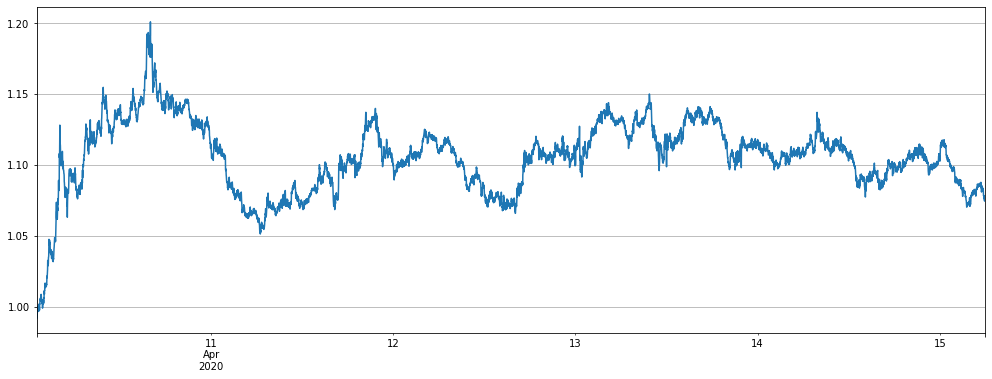

In [360]:
(stragey_1.df['total']/stragey_1.initial_balance).plot(figsize=(17,6),grid = True);

## 策略2做多超跌做空超涨盈利分析

把最后账户信息打印出来，可见大部分币种都带来了利润，BNB亏损最多，这也是主要因为BNB走出了一波独立行情，上涨不少,最大偏离了0.06。

In [367]:
pd.DataFrame(stragey_2a.account).T.apply(lambda x:round(x,3)).sort_values(by='realised_profit')

,amount,fee,hold_price,leverage,margin,price,realised_profit,total,unrealised_profit,value
BNB,-24.871,17.459,15.527,NaN,19.308,15.701,-98.445,NaN,-4.336,390.497
ONT,-304.260,6.416,0.394,NaN,6.000,0.397,-23.734,NaN,-0.913,120.913
IOST,0.000,6.066,0.003,NaN,0.000,0.003,-23.349,NaN,0.000,0.000
BCH,1.353,12.002,222.789,NaN,15.073,223.920,-21.968,NaN,1.530,302.990
VET,-104305.964,13.095,0.004,NaN,19.295,0.004,-17.984,NaN,-4.197,390.104
LTC,2.180,4.727,40.800,NaN,4.448,41.540,-11.820,NaN,1.613,90.567
TRX,9584.665,8.066,0.012,NaN,5.952,0.013,-5.932,NaN,1.250,120.288
ADA,-3573.556,7.060,0.034,NaN,6.000,0.034,-3.283,NaN,0.143,119.857
NEO,0.000,3.961,7.312,NaN,0.000,7.345,4.201,NaN,0.000,0.000
ETH,-0.190,6.102,160.908,NaN,1.529,160.600,5.217,NaN,0.059,30.525


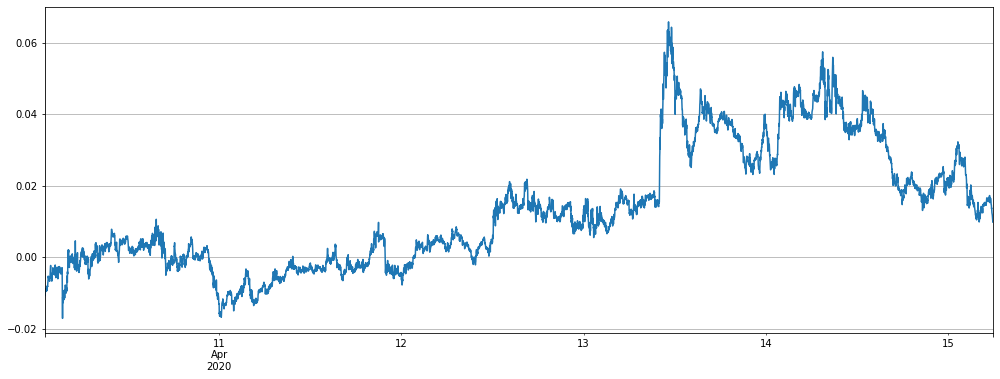

In [355]:
# BNB的偏离情况
(price_usdt_btc_norm2.iloc[-7500:].BNB-price_usdt_btc_norm_mean[-7500:]).plot(figsize=(17,6),grid = True);
#price_usdt_btc_norm_mean[-7500:].plot(figsize=(17,6),grid = True);

如果把BNB，ATOM亏损大户去掉的结果如何，表现好了一些，但最近依然是会回撤阶段。

In [363]:
Alpha = 0.001
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = list(set(symbols)-set(['BNB','ATOM']))
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.00075,log=False)
trade_value = 300
for row in price_usdt.iloc[-7500:].iterrows():
    e.Update(row[0], row[1])
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        if aim_value - now_value > 0.5*trade_value:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -0.5*trade_value:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2b = e

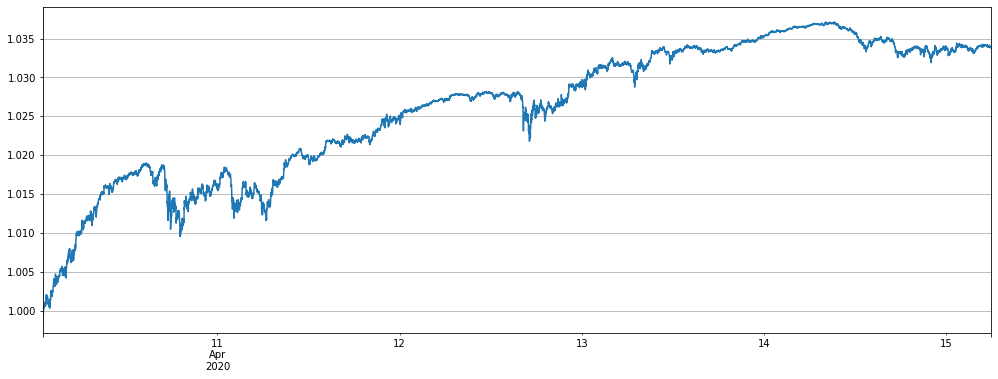

In [364]:
(stragey_2b.df['total']/stragey_2b.initial_balance).plot(figsize=(17,6),grid = True);

最近两天流行跑主流币策略，我们也回测一下这种策略。由于币种减少，trade_value适当增加4倍以对比,结果表现不错，尤其是最近回撤很小。

需要注意的是只跑主流币在更长时间的回测中是不如全币种的，回撤也更多。自己可以动手在小时线上回测以下，主要是因为币种少了资金分散，波动性反而上升。

In [365]:
Alpha = 0.001
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = ['ETH','LTC','EOS','XRP','BCH']
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.00075,log=False)
trade_value = 1200
for row in price_usdt.iloc[-7500:].iterrows():
    e.Update(row[0], row[1])
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        if aim_value - now_value > 0.5*trade_value:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -0.5*trade_value:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2c = e

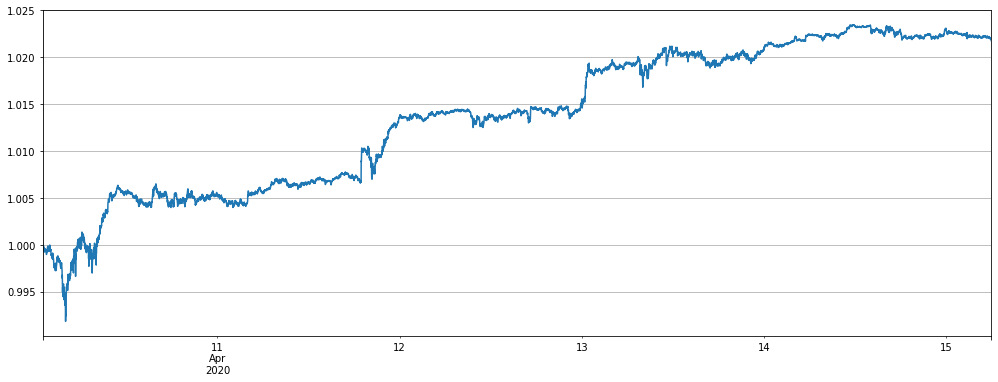

In [366]:
(stragey_2c.df['total']/e.initial_balance).plot(figsize=(17,6),grid = True);

## 手续费和策略参数分析

由于前几个报告用的都是小时线，和实盘参数情况参数很大，现在有了分钟线，就可以看出来一些参数要如何设置，首先先看默认参数的设置:

- Alpha = 0.03 指数移动平局的Alpha参数，设置的越大，基准价格跟踪越敏感，交易的越少，最终持仓也会越低，降低了杠杆，但会降低收益，降低最大回撤。
- Update_base_price_time_interval = 30\*60 多久更新一次基准价格, 单位秒，和Alpha参数相关,Alpha 设置的越小，这个间隔也可以设置的更小
- Trade_value：山寨币价格（BTC计价）每偏离指数1%持有价值，需要根据自己投入的总资金和风险偏好决定，建议设置为总资金的3-10%。可通过研究环境的回测看杠杆的大小，Trade_value可以小于Adjust_value，如Adjust_value的一半，这样相当于偏离指数2%的持有价值。
- Adjust_value： 合约价值（USDT计价）调整偏离值。 当 指数偏离 * Trade_value - 当前持仓 > Adjust_value，即目标持仓和当前持仓的差超过此值，就会开始交易。过大调整较慢，太小交易频繁，不能低于10，否则会达不到最小成交,推荐设置为Trade_value的40%以上。

Trade_value不必说，直接关系到我们的收益和风险，如果Trade_value一直没改过，到目前应该是盈利的。

Alpha由于我们这次有了更高频的数据，显然也要1min更新一次才更加合理，自然要比原来小，具体多少可以通过回测确定。

Adjust_value一直推荐Trade_value的40%以上，原来1hK线设置多少都影响不大，有些人希望调的很低，这样就可以更加紧密的贴近目标持仓，这里将会分析为什么不应该这样做。

**首先分析手续费的问题**

可以看到在默认费率0.00075的情况下，手续费293,利润为270，比例非常高。我们把手续费设为0，Adjust_value设置为10，看看会怎样。

In [369]:
stragey_2a.account['USDT']

{'fee': 293.85972778530453,
 'leverage': 0.45999999999999996,
 'margin': 236.23559736312995,
 'realised_profit': 281.77464608744435,
 'total': 10271.146238,
 'unrealised_profit': -10.628408369648495}

In [370]:
Alpha = 0.001
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = list(set(symbols))
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0,log=False)
trade_value = 300
for row in price_usdt.iloc[-7500:].iterrows():
    e.Update(row[0], row[1])
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        if aim_value - now_value > 10:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < 10:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2d = e

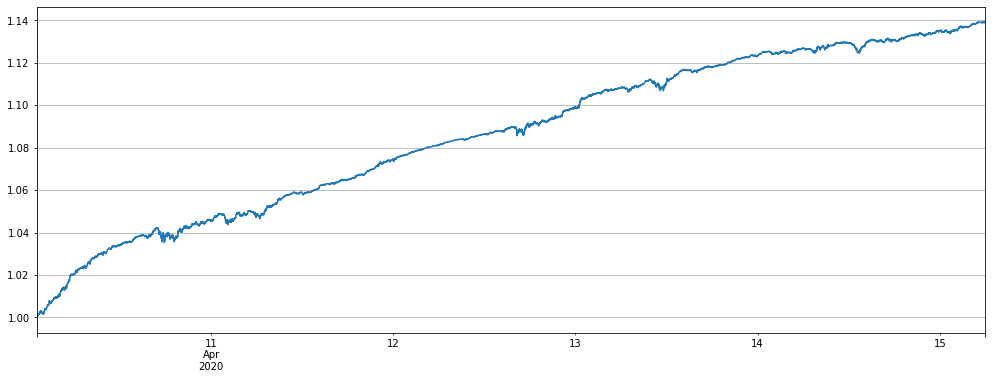

In [371]:
(stragey_2d.df['total']/e.initial_balance).plot(figsize=(17,6),grid = True);

结果是一条直线向上，BNB只是带来了一点小小的波折，较低的Adjust_value抓住了每一次波动，没有手续费利润极佳。

如果有手续费，Adjust_value很小会怎样？

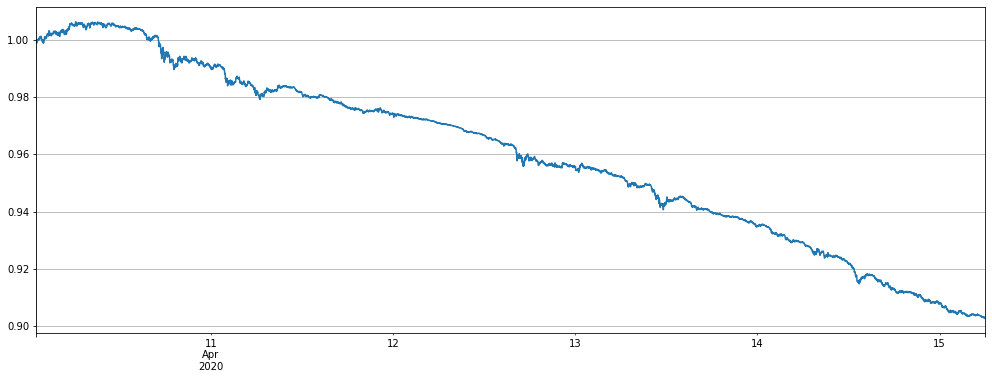

In [372]:
Alpha = 0.001
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = list(set(symbols))
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.00075,log=False)
trade_value = 300
for row in price_usdt.iloc[-7500:].iterrows():
    e.Update(row[0], row[1])
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        if aim_value - now_value > 10:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < 10:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2e = e
(stragey_2e.df['total']/e.initial_balance).plot(figsize=(17,6),grid = True);

结果也走出了一条直线下跌的曲线，想想很容易理解，在很小的差价范围频繁调整，只会亏掉手续费。

综合来看，手续费水平越低，Adjust_value可以设置的越小，交易越频繁，利润越高。

**Alpha设定的问题**

既然有了分钟线，基准价格就要一分钟更新一次，这里我们简单回测确定下alpha的大小。目前推荐Alpha设置为0.001。

In [374]:
for Alpha in [0.0001, 0.0003, 0.0006, 0.001, 0.0015, 0.002, 0.004, 0.01, 0.02]:
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
    price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
    trade_symbols = list(set(symbols))
    price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
    e = Exchange(trade_symbols,initial_balance=10000,commission=0.00075,log=False)
    trade_value = 300
    for row in price_usdt.iloc[-7500:].iterrows():
        e.Update(row[0], row[1])
        for symbol in trade_symbols:
            price = row[1][symbol]
            if np.isnan(price):
                continue
            diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
            aim_value = -trade_value*round(diff/0.01,1)
            now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
            if aim_value - now_value > 0.5*trade_value:
                e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
            if aim_value - now_value < -0.5*trade_value:
                e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
    print(Alpha, e.account['USDT']['unrealised_profit']+e.account['USDT']['realised_profit'])

0.0001 -77.80281760941007
0.0003 179.38803796199724
0.0006 218.12579924541367
0.001 271.1462377177959
0.0015 250.0014065973528
0.002 207.38692166891275
0.004 129.08021828803027
0.01 65.12410041648158
0.02 58.62356792410955


## 最近两月的分钟线回测结果

最后在看看长时间回测的结果。就在刚刚，一波此起彼伏的上涨，今日净值又新低，来给大家增强以下信心吧，由于分钟线的频率更高，将会在小时内开仓平仓，所以收益率会高很多。

还有一点，我们一直是固定的trade_value，这使得后期资金利用率不足，实际上的收益率还可以在增加很多。

在这两个月的回测时间内，我们处于什么位置哪？

<img src='https://www.fmz.com/upload/asset/274e19e6ca11dcbc289.jpg'>

In [317]:
Alpha = 0.001
#price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.rolling(20).mean() #普通均线
price_usdt_btc_norm2 = price_usdt_btc/price_usdt_btc.ewm(alpha=Alpha).mean() #这里和策略一致，用了EMA
trade_symbols = list(set(symbols))
price_usdt_btc_norm_mean = price_usdt_btc_norm2[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.00075,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm2.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        if aim_value - now_value > 0.5*trade_value:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -0.5*trade_value:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2f = e

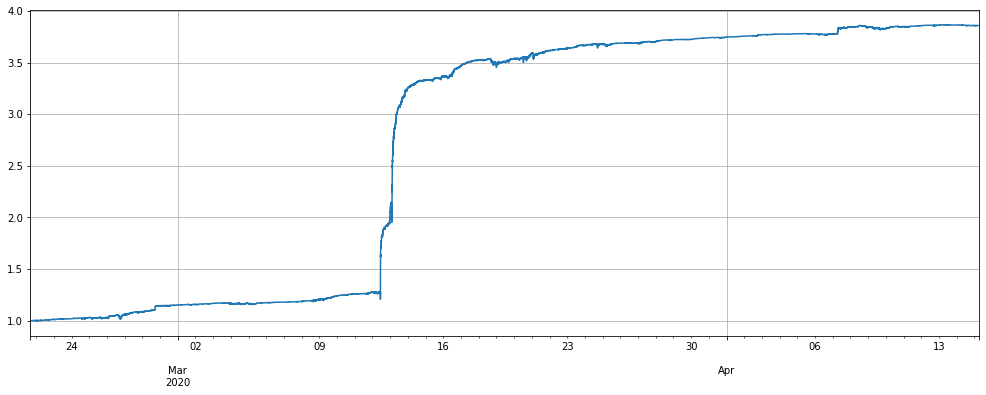

In [357]:
(stragey_2f.df['total']/stragey_2e.initial_balance).plot(figsize=(17,6),grid = True);

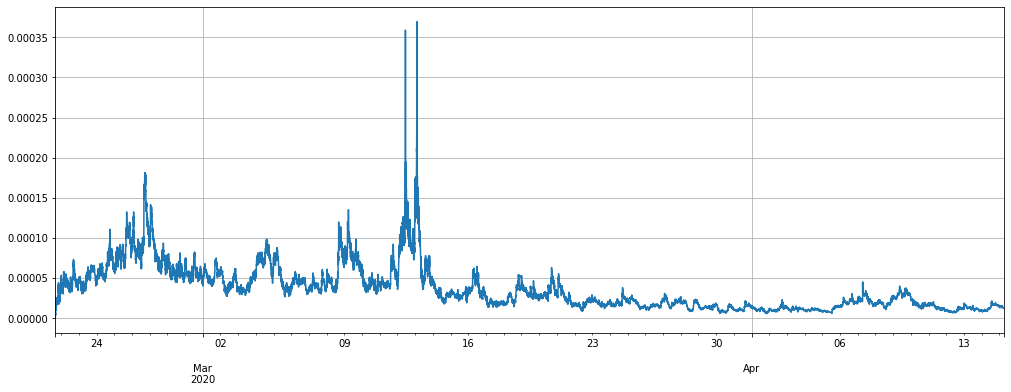

In [375]:
(stragey_2f.df['leverage']/stragey_2e.initial_balance).plot(figsize=(17,6),grid = True);